# jRDF2vec for Order-Aware RDF2vec

## Setup
These steps have to be performed only once.

### Download jRDF2vec JAR

In [6]:
!wget https://github.com/dwslab/jRDF2Vec/blob/jars/jars/jrdf2vec-1.3-SNAPSHOT.jar?raw=true -O jrdf2vec.jar &> download_log.txt

### Download and Compile Structured-word2vec

In [10]:
!git clone https://github.com/wlin12/wang2vec

Cloning into 'wang2vec'...
remote: Enumerating objects: 112, done.
remote: Total 112 (delta 0), reused 0 (delta 0), pack-reused 112
Receiving objects: 100% (112/112), 58.15 KiB | 11.63 MiB/s, done.
Resolving deltas: 100% (67/67), done.


In [13]:
!cd wang2vec && make

gcc word2vec.c -o word2vec -lm -pthread -O3 -march=native -Wall -funroll-loops -Wno-unused-result -g
gcc cngram2vec.c -o cngram2vec -lm -pthread -O3 -march=native -Wall -funroll-loops -Wno-unused-result -g
cngram2vec.c: In function ‘TrainModelThread’:
cngram2vec.c:681:13: warning: variable ‘l1’ set but not used [-Wunused-but-set-variable]
  681 |   long long l1, l2, c, target, label, local_iter = iter;
      |             ^~
gcc weightedWord2vec.c -o weightedWord2vec -lm -pthread -O3 -march=native -Wall -funroll-loops -Wno-unused-result -g
gcc wordless2vec.c -o wordless2vec -lm -pthread -O3 -march=native -Wall -funroll-loops -Wno-unused-result -g
gcc word2phrase.c -o word2phrase -lm -pthread -O3 -march=native -Wall -funroll-loops -Wno-unused-result -g
gcc distance.c -o distance -lm -pthread -O3 -march=native -Wall -funroll-loops -Wno-unused-result -g
gcc word-analogy.c -o word-analogy -lm -pthread -O3 -march=native -Wall -funroll-loops -Wno-unused-result -g
gcc compute-accuracy.c -o co

In [14]:
!mv ./wang2vec/word2vec ./word2vec

## Walk Generation

In [2]:
# generate walks
!java -jar ./jrdf2vec.jar -onlyWalks -graph ./artists_graph.nt

Using server port: 1808
Using 8 threads for walk generation and training.
Using depth 4
Generating 100 walks per entity.
Only walks are being generated, training is performed.
12 Feb 2023 10:14:51  INFO [main] (WalkGeneratorManager.java:64) - Using NxParser.
12 Feb 2023 10:14:52  INFO [main] (WalkGeneratorManager.java:99) - Model read into memory.
12 Feb 2023 10:14:52  INFO [main] (WalkGenerationManager.java:392) - Directory created.
12 Feb 2023 10:14:52  INFO [pool-1-thread-4] (WalkGenerationManager.java:426) - TOTAL PROCESSED ENTITIES: 1000
12 Feb 2023 10:14:52  INFO [pool-1-thread-4] (WalkGenerationManager.java:427) - TOTAL NUMBER OF PATHS : 38377

Total Time:
Days: 0
Hours: 0
Minutes: 0
Seconds: 1



In [3]:
# decompress walk file
!gunzip ./walks/walk_file_0.txt.gz

## Embedding Generation

In [4]:
!./word2vec -train ./walks/walk_file_0.txt -output oa100.txt -type 3 -min-count 0 -cap 1

Starting training using file ./walks/walk_file_0.txt
Vocab size: 1815
Words in train file: 629944
Alpha: 0.000170  Progress: 99.86%  Words/thread/sec: 76.08k  

## Evaluation

In [90]:
# Let's load the labels file
import pandas as pd
labels_file_path_str: str = "./bands_labels.csv"
labels_df = pd.read_csv(labels_file_path_str, sep="\t")
dfX = labels_df[["Band"]]
dfY = labels_df[["Genre"]]
labels_df

,Band,Genre
0,http://dbpedia.org/resource/Vintage_Blue,Rock
1,http://dbpedia.org/resource/Tin_Alley,Rock
2,http://dbpedia.org/resource/The_Roulettes,Rock
3,http://dbpedia.org/resource/Buhos,Rock
4,http://dbpedia.org/resource/Ripe_Banana_Skins,Rock
...,...,...
195,http://dbpedia.org/resource/Carl_Carlton,Soul
196,http://dbpedia.org/resource/Salsoul_Orchestra,Soul
197,http://dbpedia.org/resource/The_Nextmen,Soul
198,http://dbpedia.org/resource/The_Jackson_Sisters,Soul


In [123]:
import pandas as pd
dfVectors = pd.read_csv("./oa100.txt", sep = " ", skiprows=[0])
dfVectors.columns = ["Band"] + [f"v{i}" for i in range(0,101)]  
# drop last empty value
dfVectors = dfVectors[["Band"] + [f"v{i}" for i in range(0,100)]]

In [124]:
dfXvectors = pd.concat([dfX.set_index("Band"), dfVectors.set_index("Band")], axis=1, join="inner")
dfXvectors

,v0,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v90,v91,v92,v93,v94,v95,v96,v97,v98,v99
Band,,,,,,,,,,,,,,,,,,,,,
http://dbpedia.org/resource/Vintage_Blue,-0.101661,-0.153132,0.227238,-0.104191,0.169468,0.097313,0.290867,-0.172756,-0.214820,0.217480,...,-0.004670,0.093849,0.231059,0.122189,0.165482,-0.122834,-0.058840,0.076121,0.034616,-0.276353
http://dbpedia.org/resource/Tin_Alley,-0.083212,-0.194981,0.337864,-0.129091,0.182630,0.133089,0.364554,-0.103778,-0.153616,0.314491,...,0.044746,-0.000048,0.248549,0.234127,0.186773,-0.124466,0.065359,0.204907,0.052136,-0.221038
http://dbpedia.org/resource/The_Roulettes,0.567702,-0.204487,1.514109,-0.500085,0.279755,-0.418795,1.104197,-0.533400,0.357073,1.036889,...,-0.967095,-0.197416,1.005567,0.792935,1.090106,-1.029737,0.077802,0.359084,0.482350,-0.829426
http://dbpedia.org/resource/Buhos,-0.052553,-0.119792,0.331403,-0.118317,0.248885,0.111773,0.386889,-0.134541,-0.137402,0.286090,...,0.049862,-0.018661,0.183622,0.297436,0.231518,-0.137309,0.146291,0.133707,0.006297,-0.185696
http://dbpedia.org/resource/Ripe_Banana_Skins,-0.052542,-0.127018,0.321062,-0.143478,0.205448,0.100599,0.367207,-0.080136,-0.122846,0.210424,...,0.014177,0.015845,0.182946,0.259183,0.192614,-0.105572,0.081304,0.118593,0.019088,-0.220585
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
http://dbpedia.org/resource/Carl_Carlton,-0.059549,-0.332138,0.462567,-0.477867,0.425834,0.410536,0.926106,0.041566,-0.219600,-0.090409,...,-0.256882,0.197630,0.714595,0.691911,0.401502,-0.061794,0.810864,-0.077421,0.014173,0.097225
http://dbpedia.org/resource/Salsoul_Orchestra,-0.054991,-0.075850,0.234934,-0.268392,-0.036323,-0.248365,0.823546,0.150442,0.694965,0.445558,...,-0.954127,-0.029941,0.532436,1.308513,1.195635,-0.307682,0.238614,1.011102,0.107842,-1.008286
http://dbpedia.org/resource/The_Nextmen,0.163393,-0.476940,0.984449,-0.887747,-0.682041,-0.466649,1.179778,0.606094,0.047763,0.193933,...,-1.654998,0.101719,1.794894,0.429845,-0.518342,0.375744,-0.253164,0.168915,0.209550,0.038163


In [125]:
# perform PCa
import matplotlib.pyplot as plt
import sklearn
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_result = pca.fit_transform(dfXvectors)

In [130]:
principal_df = pd.DataFrame(data = pca_result, 
                          columns = ["principal component 1", "principal component 2"])
finalDf = pd.concat([principal_df, dfY], axis = 1)

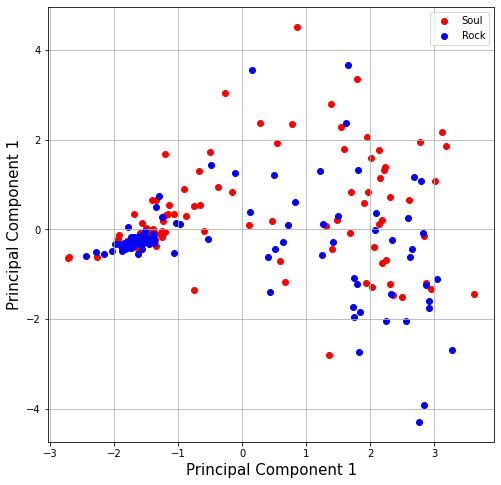

In [134]:
# prepare diagram
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel("Principal Component 1", fontsize = 15)
ax.set_ylabel("Principal Component 1", fontsize = 15)

# color codes
targets = ["Soul", "Rock"]
colors = ["r", "b"]

# create plot
for target, color in zip (targets, colors):
    indicesToKeep = finalDf["Genre"] == target
    ax.scatter(finalDf.loc[indicesToKeep, "principal component 1"],
               finalDf.loc[indicesToKeep, "principal component 2"],
               c = color)
ax.legend(targets)
ax.grid()

plt.savefig("rdf_oa_plot.png", bbox_inches='tight')